In [1]:
import os
import sys
import yaml
sys.path.append(os.path.abspath('.')) # to run files that are away
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB logs

libraries = ["torch", "numpy", "polars"]
modules   = {lib: sys.modules.get(lib) for lib in libraries}

if not modules["torch"]:
    import torch
if not modules["numpy"]:
    import numpy as np
if not modules["polars"]:
    import polars as pl

import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
"""Loading the data"""

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

data_file  = f"./datasets/{yaml_config['dataset']['filename']}"
df         = pd.read_csv(data_file)

X_scaled   = MinMaxScaler().fit_transform(df.values)
X_tensor   = torch.tensor(X_scaled, dtype=torch.float32)
X_tensor_reshaped = X_tensor.transpose(0, 1)
# dataset    = TensorDataset(X_tensor, X_tensor)  # Autoencoder reconstructs the input
dataset    = TensorDataset(X_tensor_reshaped, X_tensor_reshaped)

num_time_series = len(dataset)
# train_size = int(yaml_config['dataset']['train_valid_split'] * len(df))
train_size = int(yaml_config['dataset']['train_valid_split'] * num_time_series)
# valid_size = len(df) - train_size
valid_size = num_time_series - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])


In [3]:
"""Autoencoder training"""

import autoencoder as ae

hidden_dim        = yaml_config['autoencoder_design']['hidden_dim']
encoding_dim      = yaml_config['autoencoder_design']['encoding_dim']
latent_dim        = yaml_config['autoencoder_design']['latent_dim']
dropout_prob      = yaml_config['autoencoder_design']['dropout_prob']
training_epochs   = yaml_config['autoencoder_training']['training_epochs']
batch_size        = yaml_config['autoencoder_training']['batch_size']
optimizer_lr      = yaml_config['autoencoder_training']['optimizer_lr']
weight_decay      = yaml_config['autoencoder_training']['weight_decay']
training_patience = yaml_config['autoencoder_training']['training_patience']
scheduler_patience= yaml_config['autoencoder_training']['scheduler_patience']
scheduler_mode    = yaml_config['autoencoder_training']['scheduler_mode']
scheduler_factor  = yaml_config['autoencoder_training']['scheduler_factor']

device = ae.device
print(f"Using device from module: {device}")

# Create DataLoader objects for train and validation datasets
# input_size   = X_scaled.shape[1]
input_size   = X_scaled.shape[0]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

autoencoder  = ae.Autoencoder(input_size, hidden_dim, encoding_dim, latent_dim, dropout_prob)
optimizer    = torch.optim.AdamW(autoencoder.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, scheduler_mode, patience=scheduler_patience, factor=scheduler_factor)

ae.train_autoencoder(device, autoencoder, training_epochs, train_loader, optimizer, scheduler,
                     validation_loader=val_loader, patience = training_patience)


Using device: cpu
Using device from module: cpu
Epoch [1/30], training loss: 0.2257
Validation loss: 0.0194
Epoch [2/30], training loss: 0.2141
Validation loss: 0.0190
Epoch [3/30], training loss: 0.2157
Validation loss: 0.0188
Epoch [4/30], training loss: 0.2085
Validation loss: 0.0187
Epoch [5/30], training loss: 0.2020
Validation loss: 0.0187
Epoch [6/30], training loss: 0.2053
Validation loss: 0.0187
Epoch [7/30], training loss: 0.1938
Validation loss: 0.0191
Epoch [8/30], training loss: 0.2071
Validation loss: 0.0195
Epoch [9/30], training loss: 0.2021
Validation loss: 0.0197
Early stopping triggered


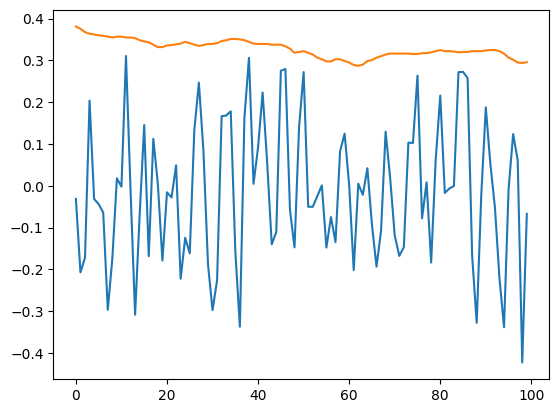

In [ ]:
"""Generate new samples from AE"""

import matplotlib.pyplot as plt

autoencoder.eval()
autoencoder.to(device)

num_gen_timeseries = X_scaled.shape[1]
latent_dim         = yaml_config['autoencoder_design']['latent_dim']
original_length    = X_tensor.shape[0]

generated_timeseries = []
with torch.no_grad():
    for _ in range(num_gen_timeseries):
        z = torch.randn(1, latent_dim).to(ae.device) # Generate random latent vector
        generated_output = autoencoder.decoder(z) # Generate output using decoder
        generated_timeseries.append(generated_output.squeeze().cpu().numpy())

# plt.plot(generated_timeseries[10][:100])
plt.plot(generated_timeseries[12][:100])
# plt.plot(X_scaled[:100, 10])
plt.plot(X_scaled[:100, 12])


# TODO: do reconstructed (encoder.output), not generated

In [ ]:
"""Eval metrics on generated samples by AE"""

from scipy.stats import kstest
from scipy.stats import wasserstein_distance as wasserstein
from statsmodels.tsa.stattools import acf
from tslearn.metrics import dtw

generated_array  = np.array(generated_timeseries)
n_features       = X_scaled.shape[1]  # Number of features
ks_stats         = []
wasserstein_dists= []
real_acfs        = []
generated_acfs   = []
dtw_distances    = []

for i in range(n_features):
    real_flat      = X_scaled[:, i].flatten()
    generated_flat = generated_array[:, i].flatten()

    # Kolg-Smir Test
    ks_statistic, _ = kstest(real_flat, generated_flat)  # We only need the statistic
    ks_stats.append(ks_statistic)

    # Wasserstein Distance
    wasserstein_dist = wasserstein(np.sort(real_flat), np.sort(generated_flat))
    wasserstein_dists.append(wasserstein_dist)

    # Autocorr. (only calculate once and store)
    if i == 0:
        real_acfs      = acf(X_scaled[:, i], nlags=20)
        generated_acfs = acf(generated_array[0], nlags=20)
    # DTW
    dtw_distance = dtw(X_scaled[:, i], generated_array[i])
    dtw_distances.append(dtw_distance)

# Print the results, calculating the averages here
print(f"Avg Kolg-Smir Statistic: {np.mean(ks_stats):.4f}")
print(f"Avg Wasserstein Distance: {np.mean(wasserstein_dists):.4f}")
print(f"Real ACF (first 5 lags): {real_acfs[:5]}")
print(f"Generated ACF (first 5 lags): {generated_acfs[:5]}")
print(f"Avg DTW Distance: {np.mean(dtw_distances):.2f}")


reconstruction_error = compute_reconstruction_loss(x_input, x_reconstructed)



Average KS Statistic: 0.8486
Average Wasserstein Distance: 0.5049
Real ACF (first 5 lags): [1.         0.75296333 0.53395633 0.4375263  0.39093748]
Generated ACF (first 5 lags): [ 1.          0.00362015  0.00532195 -0.01232835  0.00143914]
Average DTW Distance: 38.96


In [ ]:
"""Run AE on new dataset
Can be for reconstruction, anomaly detection, feature extraction, classification"""

# PAUSED, WILL PICK UP LATER

# autoencoder.eval()  # Set the model to evaluation mode (disables dropout)

# with torch.no_grad():  # No gradient computation during inference
#     x_input = torch.tensor(new_data, dtype=torch.float32)  # New data input
#     x_reconstructed = autoencoder(x_input)  # Reconstruct input

# reconstruction_error = compute_reconstruction_loss(x_input, x_reconstructed)


'Run AE on new dataset\nCan be for reconstruction, anomaly detection, feature extraction, classification'

In [ ]:
"""Diffusion training"""

import diffusion_model as diff

diff_steps        = yaml_config['diffusion_design']['diff_steps']
cos_start_offset  = yaml_config['noise_scheduler']['cos_start_offset']
noise_profile     = yaml_config['noise_scheduler']['noise_profile']
start_noise_val   = yaml_config['noise_scheduler']['start_noise_val']
end_noise_val     = yaml_config['noise_scheduler']['end_noise_val']
train_epochs      = yaml_config['diffusion_training']['train_epochs']
training_patience = yaml_config['diffusion_training']['training_patience']
optimizer_lr      = yaml_config['diffusion_training']['optimizer_lr']
weight_decay      = yaml_config['diffusion_training']['weight_decay']
scheduler_patience= yaml_config['diffusion_training']['scheduler_patience']
scheduler_mode    = yaml_config['diffusion_training']['scheduler_mode']
scheduler_factor  = yaml_config['diffusion_training']['scheduler_factor']
base_channels     = yaml_config['Unet_design']['base_channels']
dropout_prob      = yaml_config['Unet_design']['dropout_prob']

device = diff.device
print(f"Using device from module: {device}")

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(-1)  # [B, 1, L]
print(f"{X_tensor.shape=}")

betas = diff.get_noise_schedule(start_val=start_noise_val, end_val=end_noise_val, diff_steps=diff_steps,
                                cos_start_offset=cos_start_offset, noise_profile=noise_profile)
diffusion_model = diff.UNet(X_tensor.shape[1], dropout_prob, base_channels)
optimizer       = torch.optim.AdamW(diffusion_model.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
scheduler       = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epochs)

diff.train_diffusion(device, diffusion_model, train_loader, optimizer, scheduler, betas,
                     diff_steps, train_epochs, val_loader, training_patience)


Using device: cuda
Using device from module: cuda
X_tensor.shape=torch.Size([19735, 28, 1])
conv_block: in_channels = 28, out_channels = 64
conv_block: in_channels = 64, out_channels = 128
conv_block: in_channels = 128, out_channels = 256
conv_block: in_channels = 256, out_channels = 128
conv_block: in_channels = 128, out_channels = 64
Epoch [1/100], loss: 0.8332, Validation loss: 0.6627
Epoch [2/100], loss: 0.7052, Validation loss: 0.5734
Epoch [3/100], loss: 0.6679, Validation loss: 0.5392
Epoch [4/100], loss: 0.6503, Validation loss: 0.5358
Epoch [5/100], loss: 0.6391, Validation loss: 0.5215
Epoch [6/100], loss: 0.6398, Validation loss: 0.5223
Epoch [7/100], loss: 0.6341, Validation loss: 0.5133
Epoch [8/100], loss: 0.6306, Validation loss: 0.5165
Epoch [9/100], loss: 0.6265, Validation loss: 0.5036
Epoch [10/100], loss: 0.6251, Validation loss: 0.4987
Epoch [11/100], loss: 0.6220, Validation loss: 0.4970
Epoch [12/100], loss: 0.6228, Validation loss: 0.4895
Epoch [13/100], loss: 0

KeyboardInterrupt: 

In [ ]:
"""Making LDM"""

num_clients = 3
client_data = [X_scaled[:,1], X_scaled[:,2], X_scaled[:,3]]

latents = []
for data in client_data:
    latent = ae.Autoencoder.encode_to_latent
    latents.append(latent)

synth_latents = diffusion_model.forward(latents)
synth_client_latents = split(synth_latents)

for latent_data in synth_latents:
    synth_data = ae.Autoencoder.decode_from_latent(latent_data)



(19735,)

In [ ]:
is this working